In [1]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import os

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from matplotlib import pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns

import statsmodels.api as sm
import folium


# let's not pollute this blog post with warnings
from warnings import filterwarnings
filterwarnings('ignore')

/Library/Python/2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
observations = pd.read_csv(os.path.join('../data', 'Random_Walk_of_the_Penguins_-_All_penguin_observations.csv'), \
                           index_col=0)
observations.head()

site_name site_id ccamlr_region  longitude_epsg_4326  \
0  Acuna Island    ACUN          48.2              -44.637   
1  Acuna Island    ACUN          48.2              -44.637   
2  Acuna Island    ACUN          48.2              -44.637   
3  Acuna Island    ACUN          48.2              -44.637   
4  Acuna Island    ACUN          48.2              -44.637   

   latitude_epsg_4326        common_name   day  month  year  season_starting  \
0            -60.7612  chinstrap penguin  28.0   12.0  1983             1983   
1            -60.7612     adelie penguin   NaN    NaN  1993             1993   
2            -60.7612     adelie penguin   NaN    NaN  1994             1994   
3            -60.7612     adelie penguin   NaN    NaN  2004             2004   
4            -60.7612     adelie penguin  25.0    2.0  2011             2010   

   penguin_count  accuracy count_type vantage   e_n  
0         4000.0       4.0      nests  ground  0.50  
1         2008.0       1.0      nests  ground  0.05  
2         1920.0       1.0      nests     NaN  0.05  
3         1880.0       1.0      nests  ground  0.05  
4         3079.0       5.0      nests     vhr  0.90

In [3]:
print(
    "We have {} penguin observations from {} to {} at {} unique sites in the Antarctic!" \
    .format(observations.shape[0],
            observations.season_starting.min(),
            observations.season_starting.max(),
            observations.site_id.nunique())
)

We have 2952 penguin observations from 1895 to 2013 at 619 unique sites in the Antarctic!


So let's take a look at what is in the data, and see the species, where they live, and how we've estimated their populations. First, we see that there are three species in this dataset. The MAPPPD project also collects data for emporer penguins--the stars of March of the Penguins--but their populations are different from these three species, so they are not included for this competition.

In [4]:
# How many observations do we have for each species?
observations.common_name.value_counts()

adelie penguin       1387
gentoo penguin        791
chinstrap penguin     774
Name: common_name, dtype: int64

In [5]:
# How many differnet sites do we see each species at?
(observations.groupby("common_name")
             .site_id
             .nunique())

common_name
adelie penguin       281
chinstrap penguin    340
gentoo penguin       105
Name: site_id, dtype: int64

In [6]:
# How many count types do we have for each species?
(observations.groupby("common_name")
             .count_type
             .value_counts())

common_name        count_type
adelie penguin     nests         976
                   adults        223
                   chicks        188
chinstrap penguin  nests         608
                   adults         86
                   chicks         80
gentoo penguin     nests         629
                   chicks        161
                   adults          1
Name: count_type, dtype: int64

Since we have locations for our data, it's sometimes helpful to see where they are on a map. We won't incorporate this spatial information into our benchmark, but we suspect it will be useful to competitors.

In [7]:
# Give each species a color
penguin_colors = {
    'adelie penguin': rgb2hex(plt.get_cmap('Set1').colors[0]),
    'chinstrap penguin': rgb2hex(plt.get_cmap('Set1').colors[2]),
    'gentoo penguin': rgb2hex(plt.get_cmap('Set1').colors[3])
}

# Setup a map of Antarctica
ice_map = folium.Map(location=[-69.1759, -11.6016],
                     tiles='Mapbox Bright',
                     zoom_start=2,
                     min_zoom=1)

# Add 500 observations to the map
for i, row in observations.sample(500).iterrows():
    (folium.CircleMarker(location=[row.latitude_epsg_4326, row.longitude_epsg_4326],
                        radius=3 + np.sqrt(row.penguin_count) / 40,
                        color=penguin_colors[row.common_name],
                        fill_color=penguin_colors[row.common_name])
           .add_to(ice_map))

# Display the map
ice_map

Now that we've looked at all of our observations, let's turn to the prediction task for this competition--nest counts. The first thing we'll do is load the nest_count data. Note that a combination of a site_id and a common_name specify a particular timeseries, so we use the index_col=[0, 1] parameter in pandas to use both those columns in our index.



In [8]:
nest_counts = pd.read_csv(
                os.path.join('../data', 'Random_Walk_of_the_Penguins_-_Nest_count_timeseries.csv'),
                index_col=[0,1]
              )

# Let's look at the first 10 rows, and the last 10 columns
nest_counts.iloc[:10, -10:]

2004    2005    2006    2007    2008    2009  \
site_id common_name                                                         
ACUN    adelie penguin     1880.0     NaN     NaN     NaN     NaN     NaN   
        chinstrap penguin     NaN     NaN     NaN     NaN     NaN     NaN   
ADAM    adelie penguin        NaN     NaN     NaN     NaN     NaN    76.0   
ADAR    adelie penguin        NaN     NaN     NaN     NaN     NaN     NaN   
AILS    chinstrap penguin     NaN     NaN     NaN     NaN     NaN     NaN   
AITC    chinstrap penguin     NaN     NaN     NaN     NaN  5620.0     NaN   
        gentoo penguin        NaN  1998.0  1639.0  1383.0  2210.0  1900.0   
AITK    chinstrap penguin     NaN     NaN     NaN     NaN     NaN     NaN   
AKAR    adelie penguin        NaN     NaN     NaN     NaN     NaN     NaN   
ALAS    adelie penguin        NaN     NaN     NaN     NaN  1080.0     NaN   

                               2010    2011  2012      2013  
site_id common_name                                          
ACUN    adelie penguin       3079.0     NaN   NaN       NaN  
        chinstrap penguin       NaN     NaN   NaN       NaN  
ADAM    adelie penguin          NaN     NaN   NaN       NaN  
ADAR    adelie penguin     338231.0     NaN   NaN  428516.0  
AILS    chinstrap penguin       NaN     NaN   NaN       NaN  
AITC    chinstrap penguin       NaN  4047.0   NaN       NaN  
        gentoo penguin       1319.0  2213.0   NaN       NaN  
AITK    chinstrap penguin       NaN     NaN   NaN       NaN  
AKAR    adelie penguin        106.0     NaN   NaN       NaN  
ALAS    adelie penguin          NaN     NaN   NaN       NaN

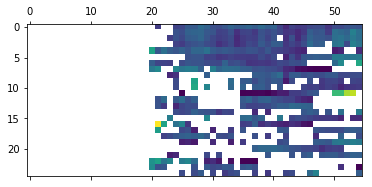

In [9]:
# get a sort order for the sites with the most observations
sorted_idx = (pd.notnull(nest_counts)
                .sum(axis=1)
                .sort_values(ascending=False)
                .index)

# get the top 25 most common sites and divide by the per-series mean
to_plot = nest_counts.loc[sorted_idx].head(25)
to_plot = to_plot.divide(to_plot.mean(axis=1), axis=0)

# plot the data
plt.gca().matshow(to_plot,
                  cmap='viridis')
plt.show()

# Handle Missing Data

We can see that there is are many gaps in observations. Most time series models don't work well with missing data, so we'll have to think about clever ways to deal with this.

For this benchmark, we're just going to keep it simple and forward fill the counts from the last recorded observation. We also don't really start to see frequent observations until after 1980, so we're going to ignore data from before that just to keep things simple.

These assumptions about filling modeling missing data is one of the most important questions in this competition. We're taking a very simple approach, but some additional sophistication in your model will improve your score drastically.



In [10]:
def preprocess_timeseries(timeseries, first_year, fillna_value=0):
    """ Takes one of the timeseries dataframes, removes
        columns before `first_year`, and fills NaN values
        with the preceeding value. Then backfills any
        remaining NaNs.
        
        As a courtesy, also turns year column name into
        integers for easy comparisons.
    """
    # column type
    timeseries.columns = timeseries.columns.astype(int)
    
    # subset to just data after first_year
    timeseries = timeseries.loc[:, timeseries.columns >= first_year]
   
    # Forward fill count values. This is a strong assumption.
    timeseries.fillna(method="ffill", axis=1, inplace=True)
    timeseries.fillna(method="bfill", axis=1, inplace=True)
    
    # For sites with no observations, fill with fill_na_value
    timeseries.fillna(fillna_value, inplace=True)
    
    return timeseries

nest_counts = preprocess_timeseries(nest_counts,
                                    1980,
                                    fillna_value=0.0)
nest_counts.head()

1980      1981      1982      1983      1984  \
site_id common_name                                                           
ACUN    adelie penguin       2008.0    2008.0    2008.0    2008.0    2008.0   
        chinstrap penguin    4000.0    4000.0    4000.0    4000.0    4000.0   
ADAM    adelie penguin         76.0      76.0      76.0      76.0      76.0   
ADAR    adelie penguin     256806.0  256806.0  256806.0  256806.0  256806.0   
AILS    chinstrap penguin    6000.0    6000.0    6000.0    6000.0    6000.0   

                               1985      1986      1987      1988      1989  \
site_id common_name                                                           
ACUN    adelie penguin       2008.0    2008.0    2008.0    2008.0    2008.0   
        chinstrap penguin    4000.0    4000.0    4000.0    4000.0    4000.0   
ADAM    adelie penguin         76.0      76.0      76.0      76.0      76.0   
ADAR    adelie penguin     256806.0  282307.0  282307.0  272338.0  272338.0   
AILS    chinstrap penguin    6000.0    6000.0    6000.0    6000.0    6000.0   

                             ...         2004      2005      2006      2007  \
site_id common_name          ...                                              
ACUN    adelie penguin       ...       1880.0    1880.0    1880.0    1880.0   
        chinstrap penguin    ...       4000.0    4000.0    4000.0    4000.0   
ADAM    adelie penguin       ...         76.0      76.0      76.0      76.0   
ADAR    adelie penguin       ...     338777.0  338777.0  338777.0  338777.0   
AILS    chinstrap penguin    ...       6000.0    6000.0    6000.0    6000.0   

                               2008      2009      2010      2011      2012  \
site_id common_name                                                           
ACUN    adelie penguin       1880.0    1880.0    3079.0    3079.0    3079.0   
        chinstrap penguin    4000.0    4000.0    4000.0    4000.0    4000.0   
ADAM    adelie penguin         76.0      76.0      76.0      76.0      76.0   
ADAR    adelie penguin     338777.0  338777.0  338231.0  338231.0  338231.0   
AILS    chinstrap penguin    6000.0    6000.0    6000.0    6000.0    6000.0   

                               2013  
site_id common_name                  
ACUN    adelie penguin       3079.0  
        chinstrap penguin    4000.0  
ADAM    adelie penguin         76.0  
ADAR    adelie penguin     428516.0  
AILS    chinstrap penguin    6000.0  

[5 rows x 34 columns]

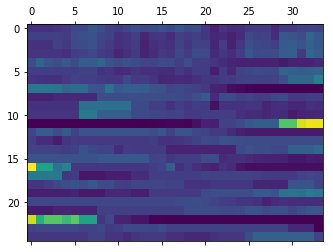

In [11]:
# get the top 25 most common sites and divide by the per-series mean
to_plot = nest_counts.loc[sorted_idx].head(25)
to_plot = to_plot.divide(to_plot.mean(axis=1), axis=0)

plt.gca().matshow(to_plot,
                cmap='viridis')
plt.show()

# The Error Metric - Adjusted MAPE
Performance is evaluated according to an adjusted MAPE calculation. 
Since some penguin counts have differing accuracies, 
the percent error is weighted differently based on this expected accuracy.

We provide e_n values for all of the data in the training set. 
Using this custom metric in your model cross-validation will help improve your score on the leaderboard. 
We'll load these per-observation error data and use that in our model fitting.

In [12]:
e_n_values = pd.read_csv(
                 os.path.join('../data', 'Random_Walk_of_the_Penguins_-_Nest_error_timeseries.csv'),
                 index_col=[0,1]
             )

# Process error data to match our nest_counts data
e_n_values = preprocess_timeseries(e_n_values, 1980, fillna_value=0.05)
e_n_values.head()

1980  1981  1982  1983  1984  1985  1986  1987  \
site_id common_name                                                         
ACUN    adelie penguin     0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05   
        chinstrap penguin  0.50  0.50  0.50  0.50  0.50  0.50  0.50  0.50   
ADAM    adelie penguin     0.90  0.90  0.90  0.90  0.90  0.90  0.90  0.90   
ADAR    adelie penguin     0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10   
AILS    chinstrap penguin  0.50  0.50  0.50  0.50  0.50  0.50  0.50  0.50   

                           1988  1989  ...   2004  2005  2006  2007  2008  \
site_id common_name                    ...                                  
ACUN    adelie penguin     0.05  0.05  ...   0.05  0.05  0.05  0.05  0.05   
        chinstrap penguin  0.50  0.50  ...   0.50  0.50  0.50  0.50  0.50   
ADAM    adelie penguin     0.90  0.90  ...   0.90  0.90  0.90  0.90  0.90   
ADAR    adelie penguin     0.10  0.10  ...   0.10  0.10  0.10  0.10  0.10   
AILS    chinstrap penguin  0.50  0.50  ...   0.50  0.50  0.50  0.50  0.50   

                           2009  2010  2011  2012  2013  
site_id common_name                                      
ACUN    adelie penguin     0.05   0.9   0.9   0.9   0.9  
        chinstrap penguin  0.50   0.5   0.5   0.5   0.5  
ADAM    adelie penguin     0.90   0.9   0.9   0.9   0.9  
ADAR    adelie penguin     0.10   0.9   0.9   0.9   0.1  
AILS    chinstrap penguin  0.50   0.5   0.5   0.5   0.5  

[5 rows x 34 columns]

In [13]:
def amape(y_true, y_pred, accuracies):
    """ Adjusted MAPE
    """
    not_nan_mask = ~np.isnan(y_true)
    
    # calculate absolute error
    abs_error = (np.abs(y_true[not_nan_mask] - y_pred[not_nan_mask]))
    
    # calculate the percent error (replacing 0 with 1
    # in order to avoid divide-by-zero errors).
    pct_error = abs_error / np.maximum(1, y_true[not_nan_mask])
    
    # adjust error by count accuracies
    adj_error = pct_error / accuracies[not_nan_mask]
    
    # return the mean as a percentage
    return np.mean(adj_error)

In [14]:
# Let's confirm the best possible score is 0!
amape(nest_counts.values,
      nest_counts.values,
      e_n_values.values)

0.0

There are many, many ways to think about building forecasts for these penguin populations.  The most accurate ones will probably use outside data as covariates in modeling the penguin populations. Here, we''ll stick to a simple model.

We''ll make the assumption that there is a linear trend to the population at each site separate site. 
We''ll also make the assumption that there are some outliers in the historical data,  so we want to only use a limited number of points to fit the model.

For every site in the dataset, we'll test fitting a model with the following procedure:

Create a train/test split like the one in the competition (4 years).
Test a linear model using only the most recent X points, where we vary X from 2 up to all of the data.
Predict with those models and see which value of X does the best on the future data.
Retrain the model on the entire dataset (through 2013) using that value of X.
Store that model and X for that site.

In [15]:
from sklearn.linear_model import LinearRegression

def train_model_per_row(ts, acc, split_year=2010):
    # Split into train/test to tune our parameter
    train = ts.iloc[ts.index < split_year]
    
    test = ts.iloc[ts.index >= split_year]
    test_acc = acc.iloc[acc.index >= split_year]
    
    # Store best lag parameter
    best_mape = np.inf 
    best_lag = None
  
    # Test linear regression models with the most recent
    # 2 points through using all of the points
    for lag in range(2, train.shape[0]):
        # fit the model
        temp_model = LinearRegression()
        temp_model.fit(
            train.index[-lag:].values.reshape(-1, 1),
            train[-lag:]
        )
        
        # make our predictions on the test set
        preds = temp_model.predict(
                    test.index.values.reshape(-1, 1)
                )

        # calculate the score using the custom metric
        mape = amape(test.values,
                     preds,
                     test_acc.values)

        # if it's the best score yet, hold on to the parameter
        if mape < best_mape:
            best_mape = mape
            best_lag = lag

    # return model re-trained on entire dataset
    final_model = LinearRegression()
    final_model.fit(
        ts.index[-best_lag:].values.reshape(-1, 1),
        ts[-best_lag:]
    )

    return final_model

Great, our training function is prepped and ready to go. Now, let's train our models!

In [16]:
models = {}

for i, row in tqdm_notebook(nest_counts.iterrows(),
                            total=nest_counts.shape[0]):
    acc = e_n_values.loc[i]
    models[i] = train_model_per_row(row, acc)

At this point, we've trained a model for every site/species combination in the dataset, so all we need to do is make our predictions for 2014-2017. We'll load the submission format so that we can use that for structuring our predictions.

In [17]:
submission_format = pd.read_csv(
    os.path.join('../data','Random_Walk_of_the_Penguins_-_Submission_Format.csv'),
    index_col=[0, 1]
)

print(submission_format.shape)
submission_format.head()

(648, 4)


2014  2015  2016  2017
site_id common_name                              
ACUN    adelie penguin      0.0   0.0   0.0   0.0
        chinstrap penguin   0.0   0.0   0.0   0.0
ADAM    adelie penguin      0.0   0.0   0.0   0.0
ADAR    adelie penguin      0.0   0.0   0.0   0.0
AILS    chinstrap penguin   0.0   0.0   0.0   0.0

And now to make our predictions! We will go through every row in the submission file. For that site_id + common_name, we'll grab our trained model and lag. We'll then use that model to predict into the future!

In [18]:
preds = []

# For every row in the submission file
for i, row in tqdm_notebook(submission_format.iterrows(),
                            total=submission_format.shape[0]):
    
    # get the model for this site + common_name
    model = models[i]
    
    # make predictions using the model
    row_predictions = model.predict(
        submission_format.columns.values.reshape(-1, 1)
    )
       
    # keep our predictions, rounded to nearest whole number
    preds.append(np.round(row_predictions))

# Create a dataframe that we can write out to a CSV
prediction_df = pd.DataFrame(preds,
                             index=submission_format.index,
                             columns=submission_format.columns)

prediction_df.head()

2014      2015      2016      2017
site_id common_name                                              
ACUN    adelie penguin       3079.0    3079.0    3079.0    3079.0
        chinstrap penguin    4000.0    4000.0    4000.0    4000.0
ADAM    adelie penguin         76.0      76.0      76.0      76.0
ADAR    adelie penguin     369067.0  372319.0  375572.0  378824.0
AILS    chinstrap penguin    6000.0    6000.0    6000.0    6000.0

# Time to make a submission
All we have to do now is save our predictions and make a submission. Just to confirm that we're following the submission format, let's look at the first few rows:

In [19]:
prediction_file = '../submissions/benchmark_predictions.csv'
prediction_df.to_csv(prediction_file)

IOError: [Errno 2] No such file or directory: '../submissions/benchmark_predictions.csv'

In [ ]:
!head -n 5 $prediction_file